In [11]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import config
import model.performance
import utility.df
import utility.iolib
import utility.plotlib
from utility.feature import Feature, FeatureCM
from model.dataEngine import DataEngine

#env = sys.argv[1] if len(sys.argv) > 2 else "dev"

In [2]:
# Setup configuration
cfg = config.ResearchConfig_MonAndAnn
time_format = cfg.CSV_TIME_FORMAT
date_format = cfg.CSV_DATE_FORMAT
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)

# Retrieve data
df_subspt, df_lesson, df_incomp, df_crclum, df_pupils = utility.iolib.retrieve_data(cfg)
print("Complete loading data for subscription and lesson history!")

Complete loading data for subscription and lesson history!


In [3]:
# Filter data
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)
first_date_impFromData = df_subspt.subscription_start_date.min()

pupils_toBeRemoved = utility.df.filter_subspt_data(
    df_subspt, first_date_impFromData, cutoff_date, remove_annual_subspt=cfg.MONTHLY_ONLY)
df_lesson1 = df_lesson[~df_lesson['pupilId'].isin(pupils_toBeRemoved)]
df_incomp1 = df_incomp[~df_incomp['pupilId'].isin(pupils_toBeRemoved)]
df_subspt1 = df_subspt[~df_subspt['pupilId'].isin(pupils_toBeRemoved)]

df_subspt1 = utility.df.compute_customer_month(df_subspt1, cfg)

# Construct dates frame
df_datesFrame = utility.df.construct_dates_frame(df_subspt1, df_lesson1, df_incomp1, cfg)
df_datesFrame.fillna(0, inplace=True)

By the cutoff date 2018-04-20, there are 1234 active subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to know the lifetime of their subscriptions. 

In the first month of dataset starting from 2014-01-01, there are 154 renewal or new subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to show if they renewed or newly joined. 

In summary, there are 1380/5685 subscribers being removed from the dataset in the analysis. 

Calculate customer month in the subscription table.


100%|██████████| 4305/4305 [00:07<00:00, 588.61it/s] 


Construct data-driven dates frame.
The dates frame has already been assigned customer month and saved in a file. The file has been loaded!


# Features

In [4]:
data_engine = DataEngine(df_subspt1, df_datesFrame, df_lesson1, df_incomp1, df_pupils, cfg)
data_engine.aggregate_features()

Construct feature object.
+ Add feature: usage time.
+ Add feature: progressions.
+ Add feature: pupils' age.
+ Add feature: outcome.
Start binning stackDepth for complete lesson table.
Start binning stackDepth for incomplete lesson table.
+ Add feature: hardship.
+ Add feature: mark.
Aggregate data over customer months.


100%|██████████| 49/49 [00:42<00:00,  1.14it/s]


In [5]:
ftr_list = ['num_attempt',  'num_complete', 'num_incomplete', 
            'last_access', 
            'active',
            'usage', 'usage_complete', 'usage_incomplete',
            'num_pass', 'num_replay', 'num_fail',
            'num_assess', 'assess', 'num_replay',
            'sum_help',
            'usage_sd2', 'num_sd2',
            'usage_sd0', 'num_sd0',
            'age',
            'mark_complete',
            'progress', 'progress_delta',
            'calendar_month',
           ]

data_engine.select_features(ftr_list)
#data_engine.transform_boxCox()

X = data_engine.data_
Xt = data_engine.data_bc_
y = data_engine.target_

df_whizz1 = data_engine.df_whizz_

In [7]:
churner = df_whizz1[df_whizz1['churn']==1]
nonchurner = df_whizz1[df_whizz1['churn']==0]

Text(0.5,0,'Usage')

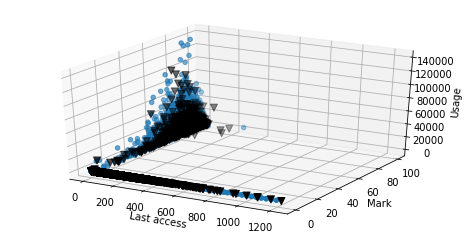

In [8]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(nonchurner.last_access, nonchurner.mark_complete, nonchurner.usage)
ax.scatter(churner.last_access, churner.mark_complete, churner.usage, marker='v', s=50, c='k')
ax.set_xlabel('Last access')
ax.set_ylabel('Mark')
ax.set_zlabel('Usage')

#ax.view_init(elev=10, azim=200)

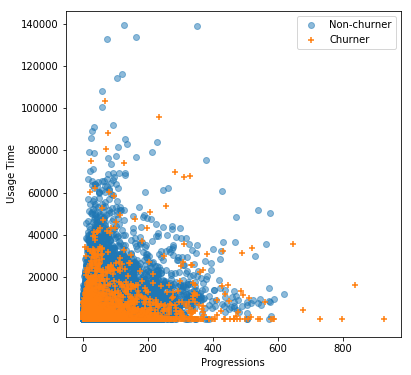

In [12]:
fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(111)

ax.scatter(nonchurner.progress, nonchurner.usage, alpha=0.5, label='Non-churner')
ax.scatter(churner.progress, churner.usage, marker='+', label='Churner')
ax.set_xlabel('Progressions')
ax.set_ylabel('Usage Time')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.legend()

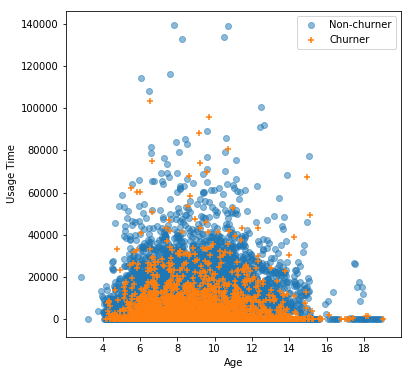

In [13]:
fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(111)

ax.scatter(nonchurner.age, nonchurner.usage, alpha=0.5, label='Non-churner')
ax.scatter(churner.age, churner.usage, marker='+', label='Churner')
ax.set_xlabel('Age')
ax.set_ylabel('Usage Time')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.legend()

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


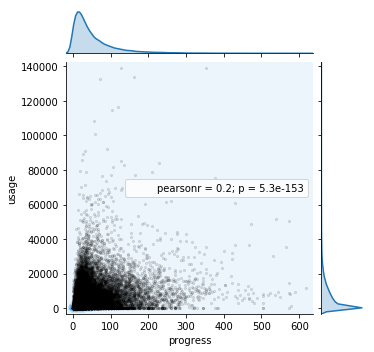

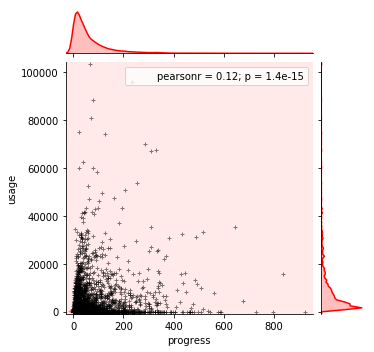

In [20]:
import seaborn as sns 

g1 = sns.jointplot(x='progress', y='usage', data=nonchurner[['progress', 'usage']], kind='kde', size=5)
g1.plot_joint(plt.scatter, c="k", s=5, linewidth=1, marker="o", alpha=0.1)

g2 = sns.jointplot(x='progress', y='usage', data=churner[['progress', 'usage']], kind='kde', color='r', size=5)
g2.plot_joint(plt.scatter, c="k", s=10, linewidth=1, marker="+", alpha=0.5)

## SVM

In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm = SVC(kernel='sigmoid', C=10, gamma=0.1).fit(X_train_scaled, y_train) # C for regularisation, gamma for width of Gaussian kernel

print('In-sample accuracy: ', svm.score(X_train_scaled, y_train))
print('Out-sample accuracy: ', svm.score(X_test_scaled, y_test))

In-sample accuracy:  0.7311848341232228
Out-sample accuracy:  0.7366824644549763


Normalised confusion matrix


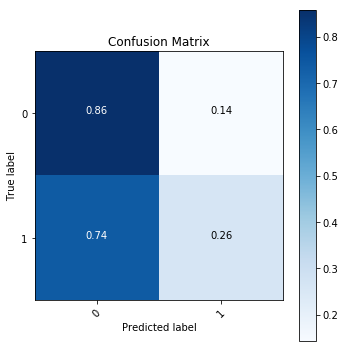

In [22]:
y_pred = svm.predict(X_test_scaled)
cm = model.performance.confusion_matrix(y_test, y_pred, [0,1])

## Decision Tree

In-sample accuracy:  0.835955766192733
Out-sample accuracy:  0.7912796208530806
Feature importance:  [0.01 0.   0.01 0.19 0.   0.02 0.28 0.02 0.01 0.01 0.01 0.01 0.   0.01
 0.02 0.   0.   0.02 0.01 0.11 0.02 0.18 0.01 0.05]
Normalised confusion matrix


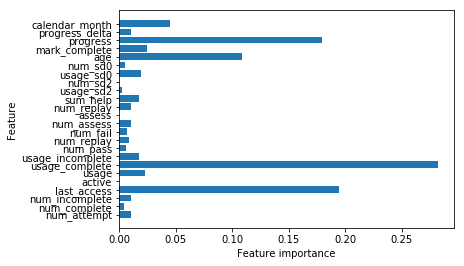

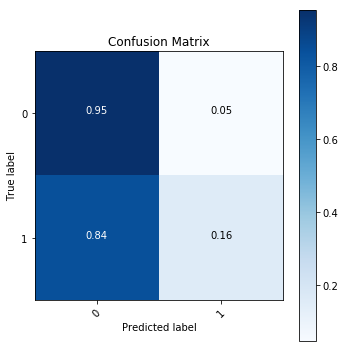

In [19]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=10, random_state=0) # the random_state here is used for tie-breaking internally
tree.fit(X_train_scaled, y_train)

print('In-sample accuracy: ', tree.score(X_train_scaled, y_train))
print('Out-sample accuracy: ', tree.score(X_test_scaled, y_test))

print("Feature importance: ", tree.feature_importances_)

def plot_feature_importances(model):
    n_features = X.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), ftr_list)
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    
plot_feature_importances(tree)

y_pred = tree.predict(X_test_scaled)
cm = model.performance.confusion_matrix(y_test, y_pred, [0,1])

## Gradient boosted regression trees

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(random_state=0, max_depth=3, learning_rate=0.1, n_estimators=1000)
gbrt.fit(X_train_scaled, y_train)

print('In-sample accuracy: ', gbrt.score(X_train_scaled, y_train))
print('Out-sample accuracy: ', gbrt.score(X_test_scaled, y_test))

In-sample accuracy:  0.8576303317535545
Out-sample accuracy:  0.8032227488151659


Normalised confusion matrix


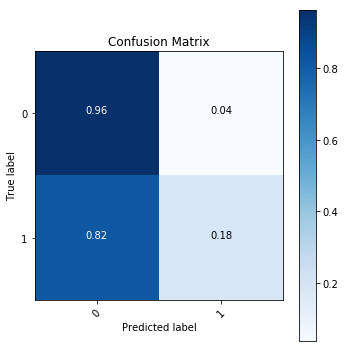

In [27]:
y_pred = gbrt.predict(X_test_scaled)
cm = model.performance.confusion_matrix(y_test, y_pred, [0,1])

## Random Forests

In [101]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=1)
forest.fit(X_train_scaled, y_train)

print('In-sample accuracy: ', forest.score(X_train_scaled, y_train))
print('Out-sample accuracy: ', forest.score(X_test_scaled, y_test))

In-sample accuracy:  0.8838983974708383
Out-sample accuracy:  0.8884892086330936


## Multilayer Perceptrons

In [38]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=10).fit(X_train_scaled, y_train)

print('In-sample accuracy: ', mlp.score(X_train_scaled, y_train))
print('Out-sample accuracy: ', mlp.score(X_test_scaled, y_test))

In-sample accuracy:  0.899113998818665
Out-sample accuracy:  0.9039688164422396


C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:427: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


KstestResult(statistic=0.10232304429759448, pvalue=4.52451318255269e-103)

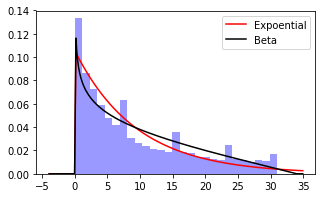

In [39]:
import seaborn as sns
from scipy import stats
from scipy.stats import expon
from scipy.stats import beta
from scipy.stats import poisson

x = df_whizz1.last_access.values

fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
sns.distplot(x, color='blue', kde=False, fit=expon, fit_kws={"color":"red", 'label':'Expoential'})
sns.distplot(x, hist=False, kde=False, fit=beta, fit_kws={"color":"k", 'label':'Beta'})

ax.legend()

x_size = x.shape[0]

e_loc, e_scale = expon.fit(x)
b_a, b_b, b_loc, b_scale = beta.fit(x)

stats.kstest(x, expon(loc=e_loc, scale=e_scale).cdf)
stats.kstest(x, beta(a=b_a, b=b_b, loc=b_loc, scale=b_scale).cdf)


## Mixture Modelling on Individual Feature

In [81]:
x = df_whizz1.rate_assess.values + 1
xt, _ = stats.boxcox(x)
xt = xt.reshape(-1,1) # reshape for single feature

from sklearn import mixture

n_components = 3

gmm = mixture.GaussianMixture(
        n_components=n_components, 
        covariance_type='diag',
        init_params='random',
        verbose=0, n_init=10, 
        tol=1e-6, max_iter=1000).fit(xt)

In [120]:
gmm.means_
gmm.covariances_[:,0]

array([3.41812712e-01, 1.00000000e-06, 9.99999714e-07])

In [118]:
gmm.weights_

array([0.58467711, 0.17362326, 0.24169963])

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


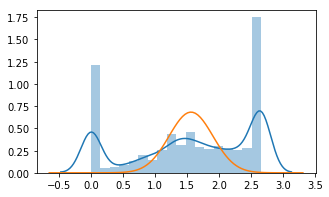

In [116]:
def mixture_distribution(gmm, array):
    mu = gmm.means_
    sigma = gmm.covariances_[:,0]
    w = gmm.weights_
    n_components = mu.shape[0]
    
    density = np.zeros(array.shape[0])
    for k in range(0, n_components):
        density += stats.norm.pdf(array, mu[k], sigma[k]) * w[k]
    
    return density

fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
sns.distplot(xt)
xlim = ax.get_xlim()
xs = np.linspace(xlim[0], xlim[1], 100)
ys = mixture_distribution(gmm, xs)
ax.plot(xs, ys)


In [131]:
k = 1
mu = gmm.means_
sigma = gmm.covariances_[:,0]
w = gmm.weights_
stats.norm.pdf(mu[k]-0.01, mu[k], sigma[k]) * w[k]

array([0.])

In [128]:
mu[k]

array([1.56467385])

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


NormaltestResult(statistic=9.285347730964737, pvalue=0.009631908736589938)

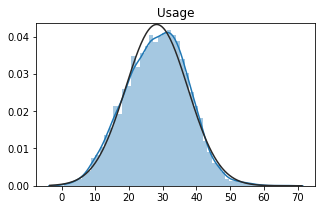

In [79]:
from scipy.stats import norm
from scipy.stats import boxcox

x = df_whizz1.usage.values+1
xt, _ = boxcox(x)

fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
sns.distplot(xt, fit=norm)
ax.set_title('Usage')

u, s = norm.fit(xt)
stats.kstest(xt, norm(u,s).cdf)

stats.normaltest(xt)


In [132]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
X = [[0, 0], [1, 1], [1, 0], [0, 1]]
y = [0, 0, 1, 1]
rbf_feature = RBFSampler(gamma=1, random_state=1)
X_features = rbf_feature.fit_transform(X)

In [134]:
X_features.shape

(4, 100)

In [ ]:
# Junaid: confussion matrix

# Feature polynomials and interactions

# Kernel density estimation of individual features

# http://pomegranate.readthedocs.io/en/latest/GeneralMixtureModel.html

# Can also try other clustering methods and then calculate the churn rate --> this can somehow verifies
# if unsupervised learning works for this classification task, and possibly the result does not rely on
# the feature distribution.

# Need to change the propotion of churners in the training set.